In [1]:
import os
from typing import  List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
import sqlite3
from langchain.tools import Tool
from langchain_core.tools import tool

connection = sqlite3.connect("gym.db")

In [2]:
os.environ["GROQ_API_KEY"] = "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"
from langchain_groq import ChatGroq

llm = ChatGroq(
    model="llama-3.3-70b-versatile",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

In [19]:

@tool
def serach_by_sub_muscle_tool(TargetedSubMuscles: str, MainMuscle: str):
    """
    Fetches exercises from the SQLite database based on targeted and main muscles.
  Args:
        inputs (str): 'TargetedMuscles' and 'MainMuscle'.
        
    Returns:
    List: A list of query results."""
    print("i am here")
    print("main muscle", MainMuscle)
    cursor = connection.cursor()
    query = """
        SELECT * 
        FROM exercises
        WHERE sub_muscles LIKE ?
        OR main_muscle LIKE ?;
    """
    # Use '%' wildcard for LIKE
    parameters = (f"%{TargetedSubMuscles}%", f"%{MainMuscle}%")
    cursor.execute(query, parameters)
    rows = cursor.fetchall()
    
    exercises = []
    for row in rows:
        exercises.append(row)
    
    return exercises

    

In [4]:
tools=[serach_by_sub_muscle_tool]

In [5]:
llm=llm.bind_tools(tools)

In [6]:
llm.invoke("i want an good exercise for my lats")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_9rbd', 'function': {'arguments': '{"MainMuscle": "Lats", "TargetedSubMuscles": "Latissimus Dorsi"}', 'name': 'serach_by_sub_muscle_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 38, 'prompt_tokens': 335, 'total_tokens': 373, 'completion_time': 0.138181818, 'prompt_time': 0.042796089, 'queue_time': 0.009913773, 'total_time': 0.180977907}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_4e32347616', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-898c7706-fd4b-482d-9f61-f5d5f3e488a9-0', tool_calls=[{'name': 'serach_by_sub_muscle_tool', 'args': {'MainMuscle': 'Lats', 'TargetedSubMuscles': 'Latissimus Dorsi'}, 'id': 'call_9rbd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 335, 'output_tokens': 38, 'total_tokens': 373})

In [7]:
class MainMuscle(TypedDict):
    main_muscle: str=Field(description="main muscle name")
    sub_muscle: List[str]=Field(description="list of sub_muscle groups")
    exercise: List[str]=Field(description="list of exercises")
    @property
    def summary(self):
        return f"name: {self.main_muscle}, description: {self.description}, exercise: {self.exercise}"

In [9]:
class Perspectives(BaseModel):
    muscle_workouts: List[MainMuscle] = Field(
        description="Comprehensive list of all workout with sub_muscles.",
    )

In [11]:
class Generate_plans(TypedDict):
    goal:str # goal of the workout_plans
    intensity: str # intensity of the workout
    tall: int 
    weight: int
    human_feedback: str
    max_exercises: int
    muscle_workouts: List[MainMuscle] # list of whole body exercise

In [12]:
import langchain_core

In [13]:
fitness_instructions="""You are tasked with retreiving and review a set of exercises for each muscle group. Follow these instructions carefully:

1. First, review the research topic:
{goal}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
{human_feedback}
3. take notes on the level of {intensity} and / or feedback above.
4. Assign one set of exercises to each main muscle group.
5. Pick the top {max_exercises} exercises for each SUB muscle group."""


In [20]:
def create_plans(state: Generate_plans):
    
    """ Create plans """
    print("i am here")
    goal=state.get('goal', '')
    intensity=state.get('intensity', '')
    human_feedback=state.get('human_feedback', '')
    max_exercises=state.get('max_exercises', 0)    
    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = fitness_instructions.format(goal=goal,
                                                            human_feedback=human_feedback, 
                                                            intensity=intensity,max_exercises=max_exercises)

    # Generate question 
    main_muscle_plans = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="serach the set of exercises with serach_by_sub_muscle_tool and enhance it.")])
    
    # Write the list of analysis to state
    return {"muscle_workouts": main_muscle_plans}

In [ ]:
def search_exercises(main: str = None, sub: str = None):
    cursor = connection.cursor()
    cursor.execute(
        """
        SELECT * 
        FROM exercises
        WHERE sub_muscles LIKE ?
        OR main_muscle LIKE ?;
        """,
        (f"%{sub}%", f"%{main}%")
    )
    rows = cursor.fetchall()
    print("I am here")
    # Display the results
    return rows


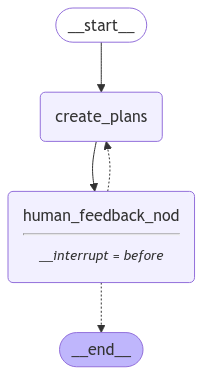

In [21]:
def human_feedback_nod(state: Generate_plans):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: Generate_plans):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_feedback', None)
    if human_analyst_feedback:
        return "create_plans"
    
    # Otherwise end
    return END

# Add nodes and edges 
builder = StateGraph(Generate_plans)
builder.add_node("create_plans", create_plans)
builder.add_node("human_feedback_nod", human_feedback_nod)
builder.add_edge(START, "create_plans")
builder.add_edge("create_plans", "human_feedback_nod")
builder.add_conditional_edges("human_feedback_nod", should_continue, ["create_plans", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback_nod'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [22]:
# Input
max_exercises = 2
goal = "lose weight"
intessity = "high"
tall=178
weight=60
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"goal":goal,"max_exercises":max_exercises,"instensity":intessity}, thread, stream_mode="values"):
    # Review
    muscle_workouts = event.get('muscle_workouts', '')
    if muscle_workouts:
        for set in muscle_workouts:
            print(set)

i am here
('muscle_workouts', [{'main_muscle': 'Chest', 'sub_muscle': ['Pectoralis Major', 'Pectoralis Minor'], 'exercise': ['Bench Press', 'Dumbbell Press', 'Incline Press']}, {'main_muscle': 'Back', 'sub_muscle': ['Latissimus Dorsi', 'Trapezius'], 'exercise': ['Pull-ups', 'Lat Pulldowns', 'Rows']}, {'main_muscle': 'Legs', 'sub_muscle': ['Quadriceps', 'Hamstrings'], 'exercise': ['Squats', 'Lunges', 'Leg Press']}, {'main_muscle': 'Shoulders', 'sub_muscle': ['Deltoids', 'Rotator Cuff'], 'exercise': ['Shoulder Press', 'Lateral Raises', 'Rear Delt Fly']}, {'main_muscle': 'Arms', 'sub_muscle': ['Biceps', 'Triceps'], 'exercise': ['Bicep Curls', 'Tricep Pushdowns', 'Overhead Dumbbell Extension']}])


In [18]:
state = graph.get_state(thread)
print(state)

StateSnapshot(values={'goal': 'lose weight', 'max_exercises': 2, 'muscle_workouts': Perspectives(muscle_workouts=[{'main_muscle': 'Chest', 'sub_muscle': ['Pectoralis Major', 'Pectoralis Minor'], 'exercise': ['Bench Press', 'Dumbbell Press', 'Incline Press']}, {'main_muscle': 'Back', 'sub_muscle': ['Latissimus Dorsi', 'Trapezius'], 'exercise': ['Pull-ups', 'Lat Pulldowns', 'Rows']}, {'main_muscle': 'Legs', 'sub_muscle': ['Quadriceps', 'Hamstrings'], 'exercise': ['Squats', 'Lunges', 'Leg Press']}, {'main_muscle': 'Shoulders', 'sub_muscle': ['Deltoids', 'Rotator Cuff'], 'exercise': ['Shoulder Press', 'Lateral Raises', 'Rear Delt Fly']}, {'main_muscle': 'Arms', 'sub_muscle': ['Biceps', 'Triceps'], 'exercise': ['Bicep Curls', 'Tricep Pushdowns', 'Overhead Dumbbell Extension']}])}, next=('human_feedback_nod',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efb9e79-7665-6672-8001-cbe35fa2ccc6'}}, metadata={'source': 'loop', 'writes': {'create_plans': {'mus